In [3]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models import vanilla_autoencoder


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

pd.options.display.width = 1000


absolute_path = "c:/thesis/data/cancer"


%load_ext tensorboard
!rm -rf ../workfiles/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


## Experiment 

loading samples...
loaded 2259 / 2259 samples
selecting genes based on median absolute deviation threshold:  2 ...
min MAD 0.0
max MAD 285733.0


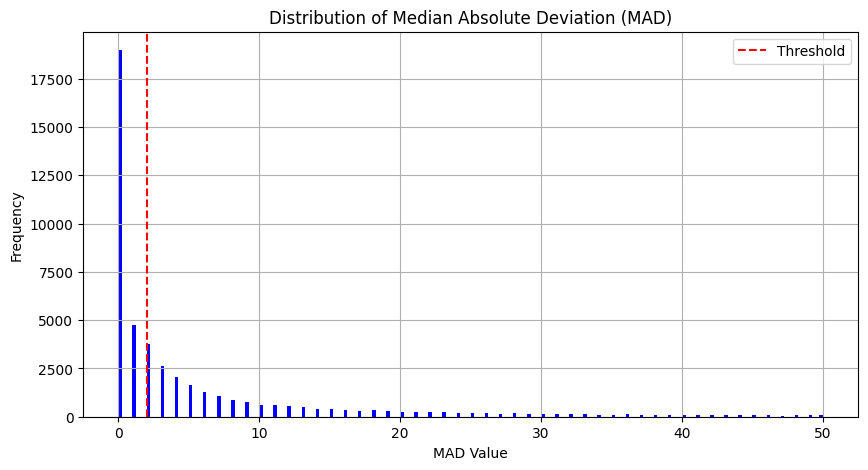

removing 39580 genes under the MAD threshold from the dataset
number of genes selected :  21080
number of genes selected :  21080
log(1 + x) transformation...
scaling to [0, 1]...
shape of the dataset : (2259, 21080)
number of seq in the dataset : 2259


In [4]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_cancer(
    path = absolute_path,
    feature_selection_threshold = 2)

In [6]:
# adding my own labels :

filenames_ = [fn.split("/")[-1] for fn in filenames]

import json
from tqdm import tqdm

with open("c:/thesis/data/cancer/metadata.cart.2023-09-11.json", 'r') as metadata_file:
    metadata = json.load(metadata_file)

# Read clinical data from TSV file
clinical = pd.read_csv("c:/thesis/data/cancer/clinical.cart.2023-09-11/clinical.tsv", sep='\t')


def get_clinical_info(given_filename):
    matching_index = None

    # Loop through metadata to find a match
    for i, item in enumerate(metadata):
        if item["file_name"] == given_filename:
            matching_index = i
            break
    
    case_id = metadata[matching_index]["associated_entities"][0]["case_id"]
    return clinical[clinical["case_id"] == case_id]["tissue_or_organ_of_origin"].values[0]

clinical_info = [get_clinical_info(filename) for filename in tqdm(filenames_)]
clinical_info[0:5]


100%|██████████| 2259/2259 [00:00<00:00, 2367.53it/s]


['Corpus uteri', 'Kidney, NOS', 'Larynx, NOS', 'Kidney, NOS', 'Kidney, NOS']

## End of experiment selection

In [7]:
importlib.reload(vanilla_autoencoder) # to allow modification of the script without restarting the whole session

latent_dim = 32

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [8]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=20, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=70)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [47]:
hist = autoencoder.fit(x_train, epochs=100, callbacks=cb) # around 16 hours for transcripts dataset 

Epoch 1/100


36/36 [==============================] - 12s 346ms/step - loss: 0.0056 - lr: 4.0000e-05
Epoch 2/100
36/36 [==============================] - 12s 344ms/step - loss: 0.0055 - lr: 4.0000e-05
Epoch 3/100
36/36 [==============================] - 12s 341ms/step - loss: 0.0055 - lr: 4.0000e-05
Epoch 4/100
36/36 [==============================] - 12s 344ms/step - loss: 0.0055 - lr: 4.0000e-05
Epoch 5/100
36/36 [==============================] - 12s 344ms/step - loss: 0.0055 - lr: 4.0000e-05
Epoch 6/100
36/36 [==============================] - 12s 347ms/step - loss: 0.0055 - lr: 4.0000e-05
Epoch 7/100
36/36 [==============================] - 12s 343ms/step - loss: 0.0055 - lr: 4.0000e-05
Epoch 8/100
36/36 [==============================] - 12s 345ms/step - loss: 0.0055 - lr: 4.0000e-05
Epoch 9/100
36/36 [==============================] - 12s 347ms/step - loss: 0.0055 - lr: 4.0000e-05
Epoch 10/100
36/36 [==============================] - 12s 346ms/step - loss: 0.0055 - lr: 4.0000e-05
Epoch 11/10

Keeping in mind that outputting a constant solution for every observation yields a loss value of ~0.2 for MT removed, log1p transformed dataset.

In [48]:
autoencoder.load_weights(checkpoint_filepath)


benchmarking model : vanilla_autoencoder
number of parametters of the model: 44502592
shape of the dataset: (2259, 21080)
the dataset meets the min_max requirement
loss: 0.005352992
adding new performer to the history


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



model_name  param_count      loss  obs_count  gene_number
0  vanilla_autoencoder     44502592  0.005547       2259        21080
0  vanilla_autoencoder     44502592  0.005353       2259        21080

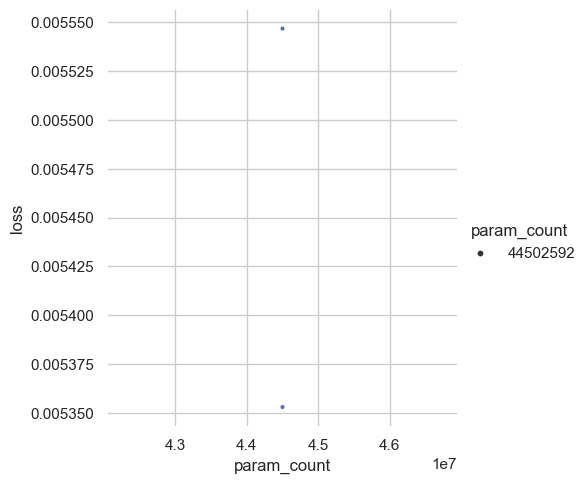

In [49]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train)

[0.005567543674260378, 0.0055628009140491486, 0.00555871706455946, 0.005554349161684513, 0.005548491142690182, 0.005542750936001539, 0.005538465455174446, 0.005534084048122168, 0.005529523827135563, 0.0055247098207473755, 0.005520651116967201, 0.00551633769646287, 0.005511838477104902, 0.005506554152816534, 0.005500818137079477, 0.0054962835274636745, 0.005493036936968565, 0.005489476025104523, 0.005485878325998783, 0.005481344647705555, 0.005477000027894974, 0.005453005433082581, 0.005460711196064949, 0.005460183136165142, 0.005457170773297548, 0.005454224068671465, 0.00545141426846385, 0.005448717158287764, 0.005446149967610836, 0.0054437522776424885, 0.005441647954285145, 0.005439430009573698, 0.005437386222183704, 0.005435430444777012, 0.005433543119579554, 0.005431425757706165, 0.005429586861282587, 0.005427842494100332, 0.005425863433629274, 0.005424218252301216, 0.005422560963779688, 0.005420804023742676, 0.005419120658189058, 0.0054173655807971954, 0.00541571993380785, 0.005414

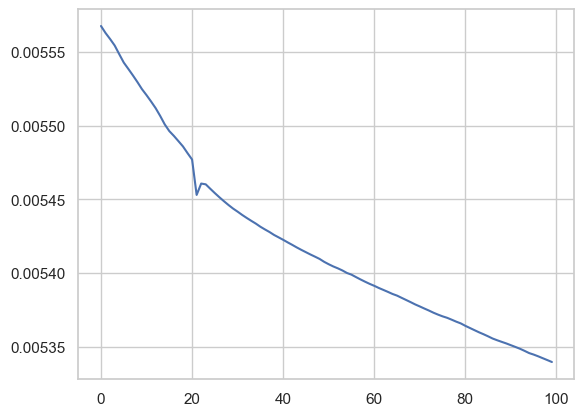

In [50]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])




### some diagnosis

In [51]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

In [52]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

 1/36 [..............................] - ETA: 0s

36/36 [==============================] - 0s 5ms/step


In [53]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

71/71 [==============================] - 0s 1ms/step


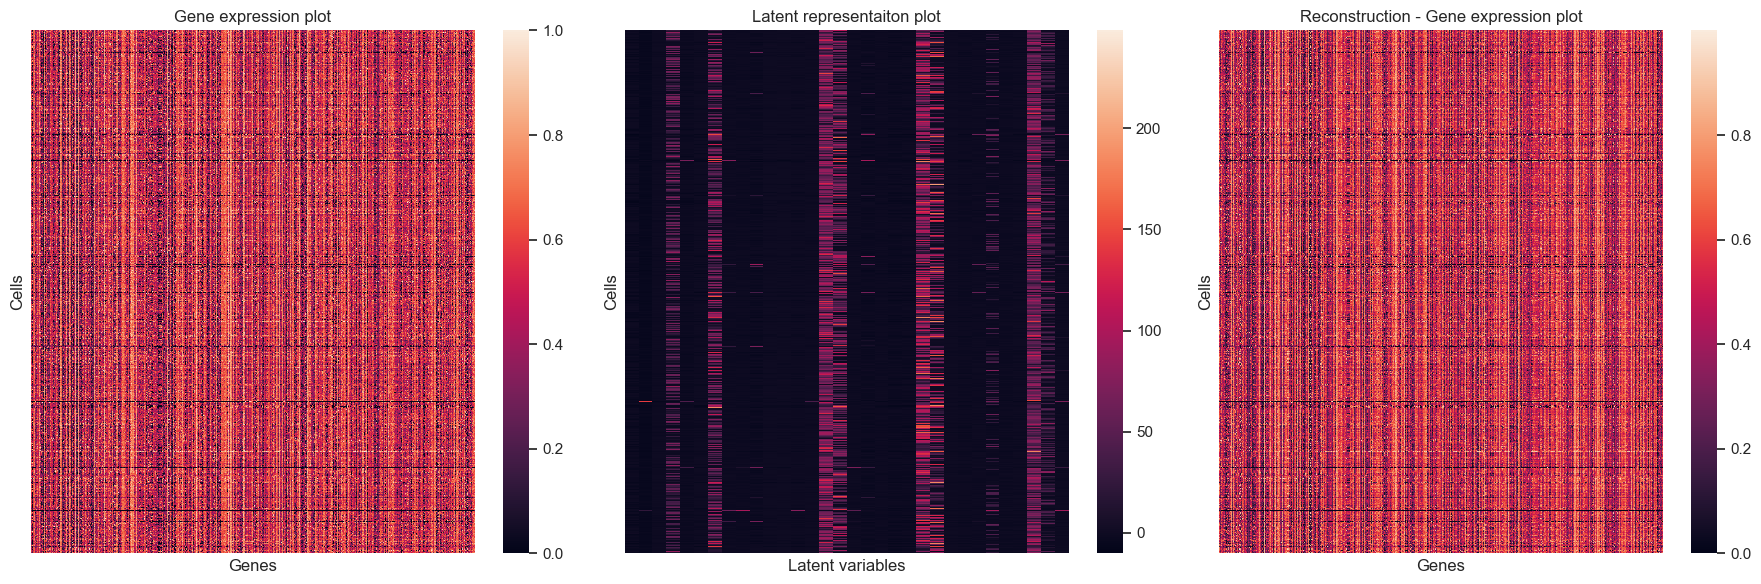

In [54]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)

In [55]:
label = pd.Series(clinical_info)

######################## OG Groups : 


c:\thesis\genome_analysis_parkinson\genome_analysis_parkinson\thesis_related\../src\utils\visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



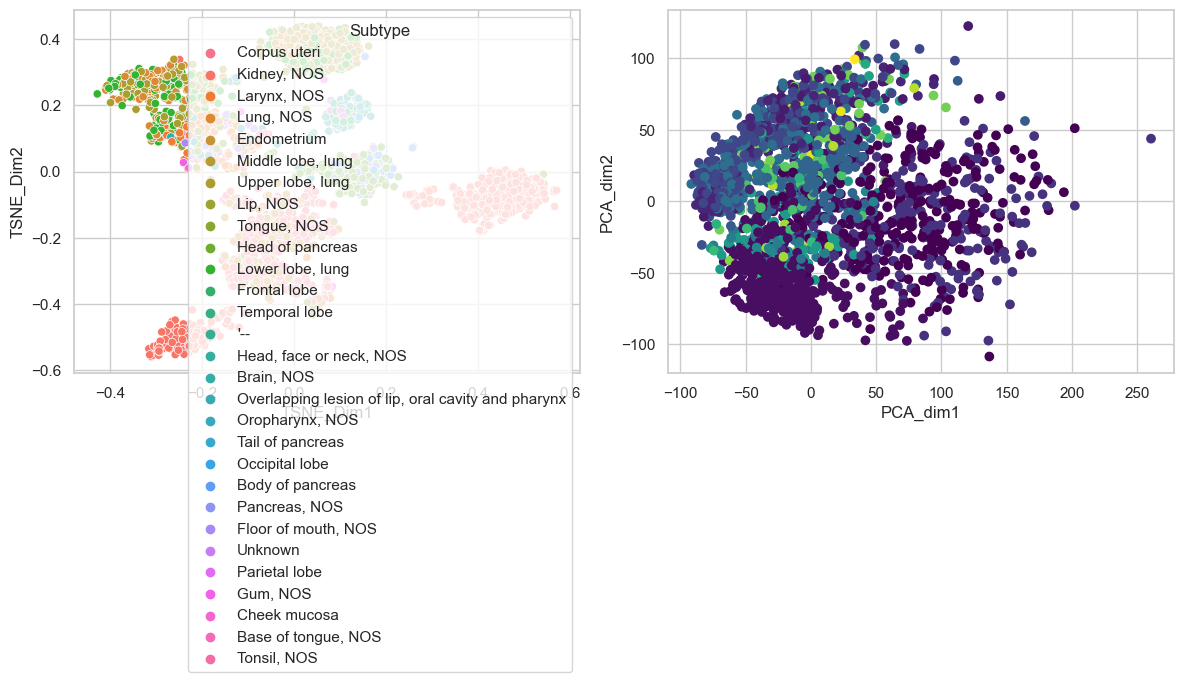

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:1877: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:1883: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



Silhouette Score: -0.0771
Dunn Index: 0.0321
Davies-Bouldin Index: 6.8758
######################## KNMEANS : 


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Py

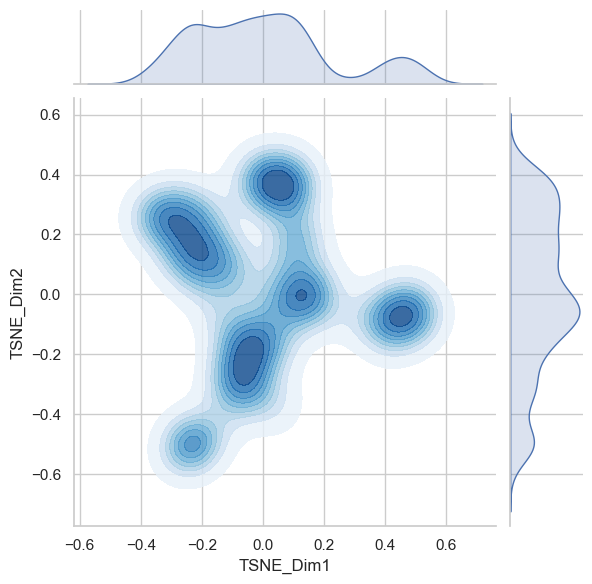

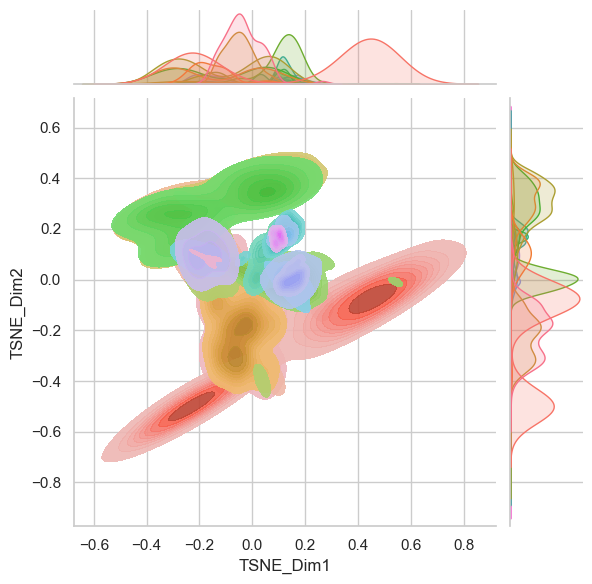

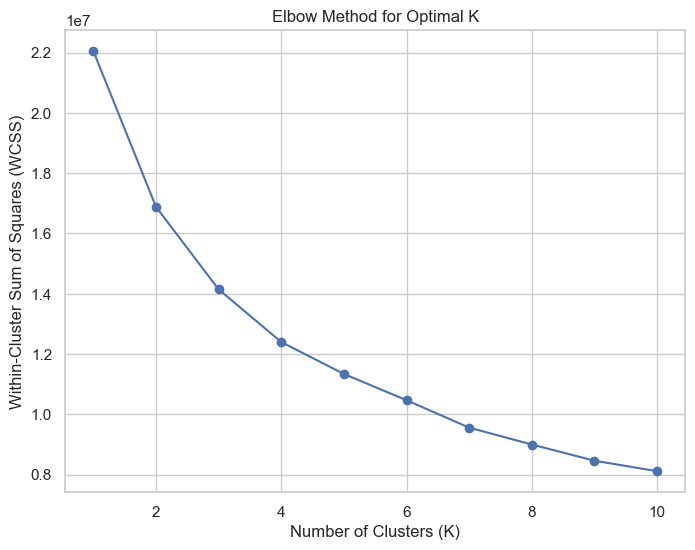

nothing found
######################## DBSCAN : 
Number of clusters: 0
nothing found


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [56]:
import helpers

importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
TSNE_params = {
            "early_exaggeration" : 50,
            "learning_rate" : 500, 
            #"perplexity" : 75, 
            "perplexity" : 100, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 2000,
            "n_components" : 2
        }
visualisation.plot_clusters(compressed_dataframe, label, TSNE_params)
benchmark.print_metrics(compressed_dataframe, label)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(compressed_dataframe)
if(len(np.unique(kmeans_labels)) == 1):
    print("nothing found")
else:   
    visualisation.plot_clusters(compressed_dataframe, kmeans_labels, TSNE_params)
    benchmark.print_metrics(compressed_dataframe, kmeans_labels)

print("######################## DBSCAN : ")
DBSCAN_labels = helpers.auto_DBSCAN(compressed_dataframe)
if(len(np.unique(DBSCAN_labels)) > 1): 
    benchmark.print_metrics(compressed_dataframe, DBSCAN_labels)
    visualisation.plot_clusters(compressed_dataframe, DBSCAN_labels, TSNE_params)
else :
    print("nothing found")

In [57]:
from sklearn.manifold import TSNE

True_labels = label.tolist()

#### TSNE

TSNE_params = {
    "early_exaggeration" : 50,
    "learning_rate" : 500, 
    "perplexity" : 15, 
    "min_grad_norm" : 1e-7, 
    "n_iter" : 5000,
    "n_components" : 2
}
tsne = TSNE(**TSNE_params).fit_transform(compressed_dataframe)
x_min, x_max = np.min(tsne, 0), np.max(tsne, 0)
tsne = tsne / (x_max - x_min)

TSNE_result = pd.DataFrame(tsne, columns=['TSNE_Dim1', 'TSNE_Dim2'])



[-1 -1 -1 ... -1 -1 -1]


<Axes: xlabel='TSNE_Dim1', ylabel='TSNE_Dim2'>

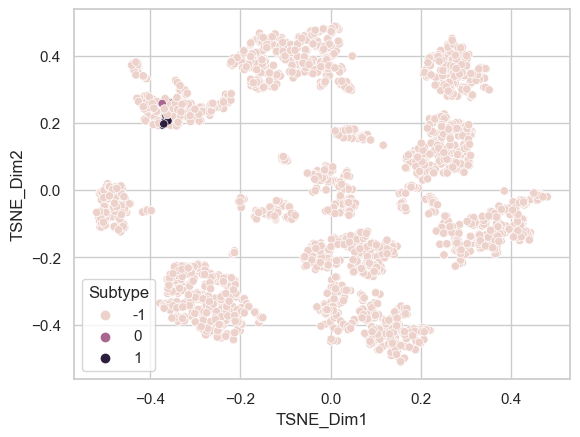

In [118]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 10, min_samples= 5,)
#dbscan = DBSCAN()
dbscan.fit(compressed_dataframe)
#dbscan.fit(TSNE_result)
cluster_labels = dbscan.labels_
print(cluster_labels)



TSNE_result['Subtype'] = cluster_labels

# Map string labels to numeric values
my_cmap = plt.get_cmap('viridis', len(TSNE_result['Subtype'].unique()))
subtype_labels = TSNE_result['Subtype'].unique()
subtype_to_numeric = {subtype: i for i, subtype in enumerate(subtype_labels)}
colors = [my_cmap(subtype_to_numeric[subtype]) for subtype in TSNE_result['Subtype']]




# Plot the first subplot (tsne)
sns.scatterplot(data=TSNE_result, x='TSNE_Dim1', y='TSNE_Dim2', hue='Subtype')

######################## KNMEANS : 


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Py

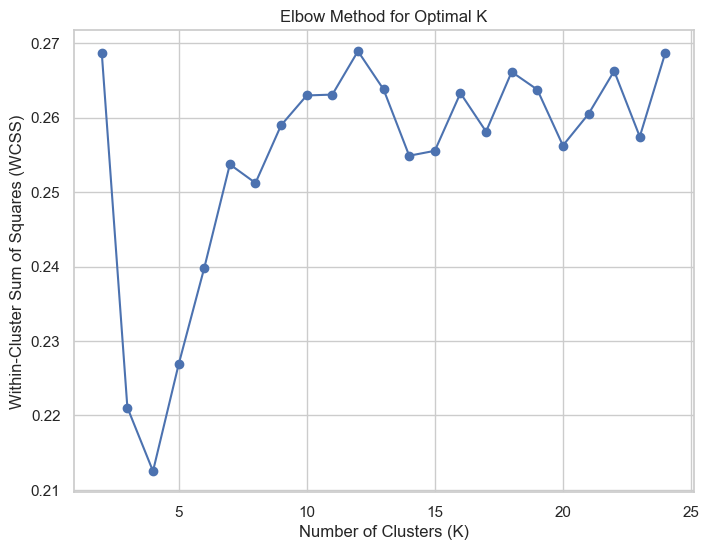

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\thesis\genome_analysis_parkinson\genome_analysis_parkinson\thesis_related\../src\utils\visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



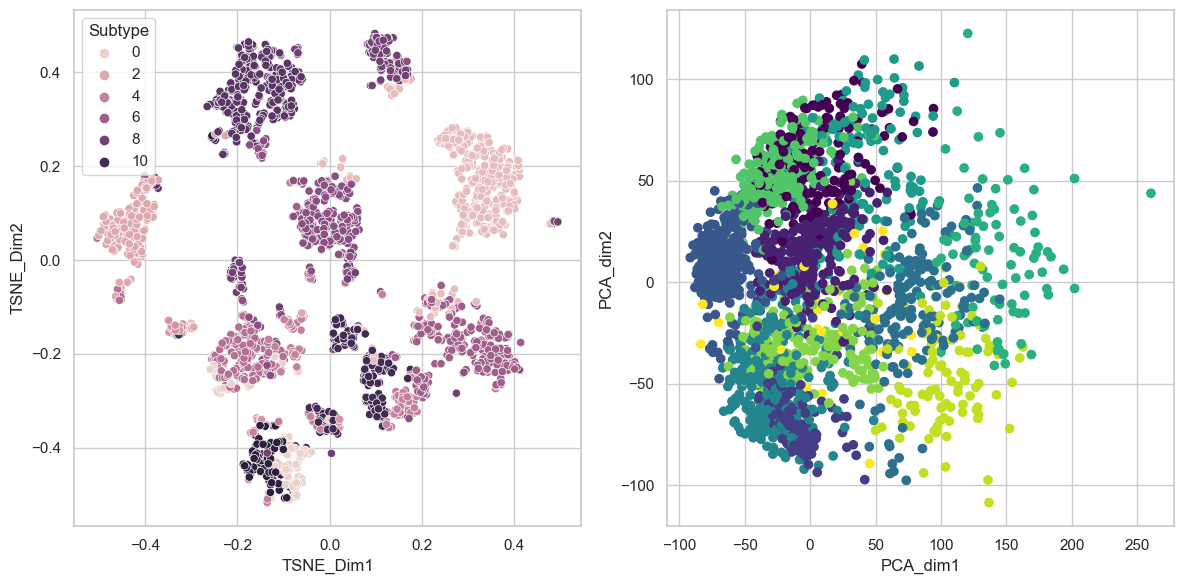

Silhouette Score: 0.2689
Dunn Index: 0.3188
Davies-Bouldin Index: 1.4490


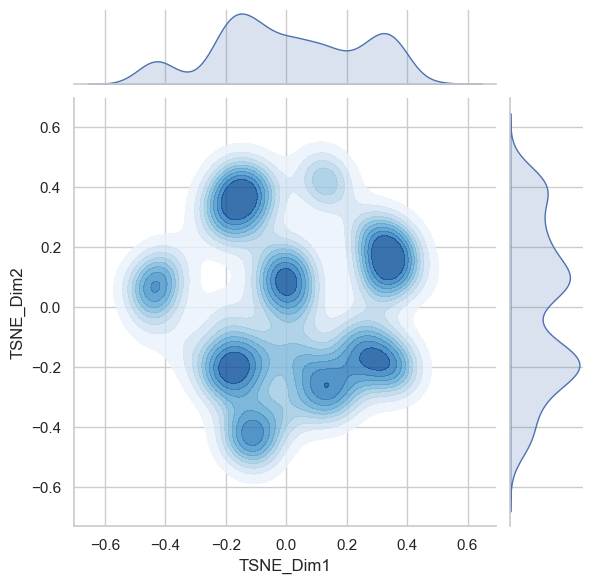

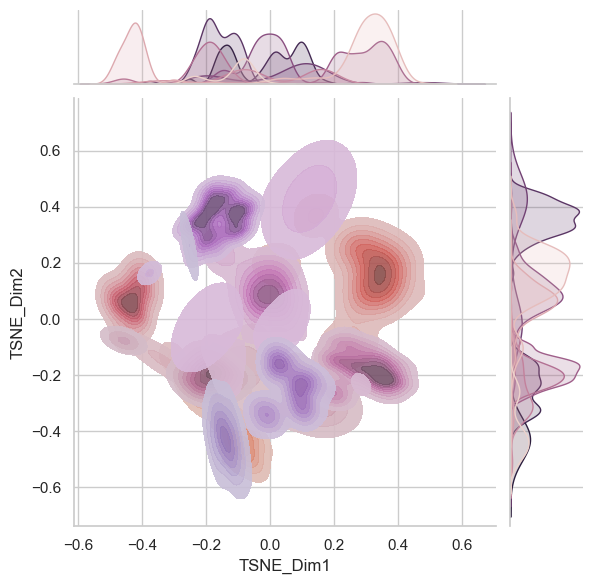

In [125]:
importlib.reload(helpers)
print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(compressed_dataframe)
if(len(np.unique(kmeans_labels)) == 1):
    print("nothing found")
else:   
    visualisation.plot_clusters(compressed_dataframe, kmeans_labels, TSNE_params)
    benchmark.print_metrics(compressed_dataframe, kmeans_labels)
